# ANLI Baseline with LLM

You have to implement in this notebook a baseline for ANLI classification using an LLM.
This baseline must be implemented using DSPy.



In [ ]:
# Configure the DSPy environment with the language model - for grok the parameters must be:
# env variable should be in os.environ['XAI_API_KEY']
# "xai/grok-3-mini"
import os
import dspy

os.environ['XAI_API_KEY'] = 'YOUR_API_KEY'

lm = dspy.LM('xai/grok-3-mini', api_key=os.environ['XAI_API_KEY'])
# for ollama 
# lm = dspy.LM('ollama_chat/devstral', api_base='http://localhost:11434', api_key='')
dspy.configure(lm=lm)

## LLM Setup

In [20]:
from typing import Literal

## Implement the DSPy classifier program.
class ANLIClassifier(dspy.Signature):
    """Classify the relationship between a premise and hypothesis for natural language inference.
    
    Given a premise and hypothesis, determine their relationship:
    - Return 0 if the hypothesis is entailed by the premise
    - Return 1 if the hypothesis is neutral (neither entailed nor contradicted)
    - Return 2 if the hypothesis contradicts the premise
    """
    premise: str = dspy.InputField(desc="The premise statement")
    hypothesis: str = dspy.InputField(desc="The hypothesis statement")
    label: int = dspy.OutputField(desc="Classification label: 0=entailment, 1=neutral, 2=contradiction")

class LLMNLIProgram(dspy.Module):
    def __init__(self):
        super().__init__()
        self.classifier = dspy.Predict(ANLIClassifier)
    
    def forward(self, premise, hypothesis):
        result = self.classifier(premise=premise, hypothesis=hypothesis)
        # Ensure the label is an integer and within valid range
        try:
            label = int(result.label)
            if label not in [0, 1, 2]:
                label = 1  # Default to neutral if invalid
            result.label = label
        except (ValueError, AttributeError):
            result.label = 1  # Default to neutral if parsing fails
        return result

# Initialize the LLM program
llm_program = LLMNLIProgram()
print("LLM DSPy program initialized!")

LLM DSPy program initialized!


## DeBERTa Setup

In [15]:
# Load DeBERTa baseline model
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_name = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
deberta_model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

def deberta_predict(premise, hypothesis):
    """Predict using DeBERTa model"""
    input_tokens = tokenizer(premise, hypothesis, truncation=True, return_tensors="pt")
    input_tokens = {k: v.to(device) for k, v in input_tokens.items()}
    
    with torch.no_grad():
        output = deberta_model(**input_tokens)
        prediction = torch.softmax(output.logits[0], -1).tolist()
    
    # Return the predicted label (0=entailment, 1=neutral, 2=contradiction)
    return prediction.index(max(prediction))

print("DeBERTa model loaded successfully!")

DeBERTa model loaded successfully!


## Optimizing LLM

Make sure you load the ANLI dataset before running the optimization.

In [17]:
# Prepare data for DSPy optimization using dev_r3
def prepare_dspy_examples(dataset_split, max_examples=None):
    """Convert dataset to DSPy examples"""
    examples = []
    for i, item in enumerate(dataset_split):
        if max_examples and i >= max_examples:
            break
        example = dspy.Example(
            premise=item['premise'],
            hypothesis=item['hypothesis'],
            label=item['label']
        ).with_inputs('premise', 'hypothesis')
        examples.append(example)
    return examples

# Prepare optimization data from dev_r3 (20-100 examples as requested)
print("Preparing optimization data from dev_r3...")
dev_examples = prepare_dspy_examples(dataset['dev_r3'], max_examples=50)
print(f"Prepared {len(dev_examples)} examples for optimization")

Preparing optimization data from dev_r3...
Prepared 50 examples for optimization


In [21]:
from dspy.teleprompt import BootstrapFewShot

def validate_answer(example, pred, trace=None):
    """Validation function for DSPy optimization"""
    try:
        # Handle both string and integer predictions
        if isinstance(pred.label, str):
            predicted_label = int(pred.label)
        else:
            predicted_label = pred.label
        
        # Ensure label is within valid range
        if predicted_label not in [0, 1, 2]:
            return False
            
        return predicted_label == example.label
    except (ValueError, AttributeError, TypeError):
        return False

# Configure the teleprompter for optimization
print("Setting up DSPy optimization...")
teleprompter = BootstrapFewShot(
    metric=validate_answer,
    max_bootstrapped_demos=4,  # Number of examples to bootstrap
    max_labeled_demos=8,       # Maximum number of labeled demonstrations
    max_rounds=3               # Number of optimization rounds
)

print("Starting DSPy program optimization...")
print("This may take several minutes depending on the number of examples and API calls...")

# Optimize the program
optimized_llm_program = teleprompter.compile(llm_program, trainset=dev_examples)

print("DSPy program optimization completed!")

Setting up DSPy optimization...
Starting DSPy program optimization...
This may take several minutes depending on the number of examples and API calls...


  8%|▊         | 4/50 [00:13<02:36,  3.40s/it]

Bootstrapped 4 full traces after 4 examples for up to 3 rounds, amounting to 4 attempts.
DSPy program optimization completed!


## Defining evaluation functions for models

In [27]:
from tqdm import tqdm

def evaluate_llm_model(program, test_data):
    """Evaluate the LLM model on test examples"""
    predictions = []
    references = []
    
    print(f"Evaluating LLM on {len(test_data)} examples...")
    
    for i, example in enumerate(tqdm(test_data, desc="LLM Evaluation")):
        try:
            result = program(premise=example['premise'], hypothesis=example['hypothesis'])
            
            # Handle label conversion safely
            if isinstance(result.label, str):
                pred_label = int(result.label)
            else:
                pred_label = result.label
            
            if pred_label not in [0, 1, 2]:
                pred_label = 1  # Default to neutral
                
            predictions.append(pred_label)
            references.append(example['label'])
            
        except Exception as e:
            print(f"Error processing example {i}: {e}")
            # Use neutral as default prediction in case of error
            predictions.append(1)
            references.append(example['label'])
    
    return predictions, references

In [28]:
def evaluate_deberta_model(test_data):
    """Evaluate the DeBERTa model on test examples"""
    predictions = []
    references = []
    
    print(f"Evaluating DeBERTa on {len(test_data)} examples...")
    
    for i, example in enumerate(tqdm(test_data, desc="DeBERTa Evaluation")):   
        try:
            pred_label = deberta_predict(example['premise'], example['hypothesis'])
            predictions.append(pred_label)
            references.append(example['label'])
        except Exception as e:
            print(f"Error processing example {i}: {e}")
            # Use neutral as default prediction in case of error
            predictions.append(1)
            references.append(example['label'])
    
    return predictions, references

## Load ANLI dataset

In [12]:
from datasets import load_dataset

dataset = load_dataset("facebook/anli")
dataset = dataset.filter(lambda x: x['reason'] != None and x['reason'] != "")

c:\Users\gilba\Git_vscode\nlp-with-llms\hw2\nli-xplain\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
dataset

DatasetDict({
    train_r1: Dataset({
        features: ['uid', 'premise', 'hypothesis', 'label', 'reason'],
        num_rows: 2923
    })
    dev_r1: Dataset({
        features: ['uid', 'premise', 'hypothesis', 'label', 'reason'],
        num_rows: 1000
    })
    test_r1: Dataset({
        features: ['uid', 'premise', 'hypothesis', 'label', 'reason'],
        num_rows: 1000
    })
    train_r2: Dataset({
        features: ['uid', 'premise', 'hypothesis', 'label', 'reason'],
        num_rows: 4861
    })
    dev_r2: Dataset({
        features: ['uid', 'premise', 'hypothesis', 'label', 'reason'],
        num_rows: 1000
    })
    test_r2: Dataset({
        features: ['uid', 'premise', 'hypothesis', 'label', 'reason'],
        num_rows: 1000
    })
    train_r3: Dataset({
        features: ['uid', 'premise', 'hypothesis', 'label', 'reason'],
        num_rows: 13375
    })
    dev_r3: Dataset({
        features: ['uid', 'premise', 'hypothesis', 'label', 'reason'],
        num_rows: 1200


## Evaluate Metrics

Let's use the huggingface `evaluate` package to compute the performance of the baseline.


In [23]:
from evaluate import load

accuracy = load("accuracy")
precision = load("precision")
recall = load("recall")
f1 = load("f1")


In [24]:
import evaluate
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

In [25]:
clf_metrics.compute(predictions=[0, 1, 0], references=[0, 1, 1])

{'accuracy': 0.6666666666666666,
 'f1': 0.6666666666666666,
 'precision': 1.0,
 'recall': 0.5}

## Your Turn

Compute the classification metrics on the baseline LLM model on each test section of the ANLI dataset for samples that have a non-empty 'reason' field.

You also must show a comparison between the DeBERTa baseline model and this LLM baseline model. The comparison metric should compute the agreement between the two models:
* On how many samples they are both correct [Correct]
* On how many samples Model1 is correct and Model2 is incorrect [Correct1]
* On how many samples Model1 is incorrect and Model2 is correct [Correct2]
* On how many samples both are incorrect [Incorrect]

In [29]:
# Evaluate on test_r3 partition only (1,200 samples as requested)

test_r3_data = list(dataset['test_r3'])
print(f"Actual test_r3 samples: {len(test_r3_data)}")

# Evaluate baseline LLM model (unoptimized)
print(f"\n--- Baseline LLM Evaluation on test_r3 ---")
baseline_llm_predictions, references = evaluate_llm_model(llm_program, test_r3_data)

Actual test_r3 samples: 1200

--- Baseline LLM Evaluation on test_r3 ---
Evaluating LLM on 1200 examples...


LLM Evaluation: 100%|██████████| 1200/1200 [2:02:39<00:00,  6.13s/it]     


In [30]:
print(f"\n--- Optimized LLM Evaluation on test_r3 ---")
optimized_llm_predictions, _ = evaluate_llm_model(optimized_llm_program, test_r3_data)


--- Optimized LLM Evaluation on test_r3 ---
Evaluating LLM on 1200 examples...


LLM Evaluation: 100%|██████████| 1200/1200 [1:34:42<00:00,  4.74s/it] 


In [31]:
# Evaluate DeBERTa model  
print(f"\n--- DeBERTa Evaluation on test_r3 ---")
deberta_predictions, _ = evaluate_deberta_model(test_r3_data)


--- DeBERTa Evaluation on test_r3 ---
Evaluating DeBERTa on 1200 examples...


DeBERTa Evaluation: 100%|██████████| 1200/1200 [05:12<00:00,  3.84it/s]


## Results

In [ ]:
references

In [ ]:
baseline_llm_predictions

In [ ]:
optimized_llm_predictions

In [ ]:
deberta_predictions

## Metrics

In [37]:
# Compute metrics for all models separately to handle different parameters
def compute_all_metrics(predictions, references):
    """Compute all metrics with appropriate parameters"""
    results = {}
    
    # Accuracy doesn't take 'average' parameter
    results['accuracy'] = accuracy.compute(predictions=predictions, references=references)['accuracy']
    
    # Other metrics take 'average' parameter
    results['precision'] = precision.compute(predictions=predictions, references=references, average='macro')['precision']
    results['recall'] = recall.compute(predictions=predictions, references=references, average='macro')['recall']
    results['f1'] = f1.compute(predictions=predictions, references=references, average='macro')['f1']
    
    return results

# Compute metrics for all models
baseline_llm_results = compute_all_metrics(baseline_llm_predictions, references)
optimized_llm_results = compute_all_metrics(optimized_llm_predictions, references)
deberta_results = compute_all_metrics(deberta_predictions, references)

print(f"\ntest_r3 Results Summary:")
print(f"Baseline LLM   - Accuracy: {baseline_llm_results['accuracy']:.4f}, F1: {baseline_llm_results['f1']:.4f}")
print(f"Optimized LLM  - Accuracy: {optimized_llm_results['accuracy']:.4f}, F1: {optimized_llm_results['f1']:.4f}")
print(f"DeBERTa        - Accuracy: {deberta_results['accuracy']:.4f}, F1: {deberta_results['f1']:.4f}")

# Show optimization improvement
accuracy_improvement = optimized_llm_results['accuracy'] - baseline_llm_results['accuracy']
f1_improvement = optimized_llm_results['f1'] - baseline_llm_results['f1']
print(f"LLM Optimization Impact - Accuracy: {accuracy_improvement:+.4f}, F1: {f1_improvement:+.4f}")


test_r3 Results Summary:
Baseline LLM   - Accuracy: 0.6875, F1: 0.6931
Optimized LLM  - Accuracy: 0.7000, F1: 0.7048
DeBERTa        - Accuracy: 0.4950, F1: 0.4943
LLM Optimization Impact - Accuracy: +0.0125, F1: +0.0117


In [38]:
def compute_agreement_metrics(model1_preds, model2_preds, references, model1_name="Model1", model2_name="Model2"):
    """Compute agreement metrics between two models"""
    
    model1_correct = [p == r for p, r in zip(model1_preds, references)]
    model2_correct = [p == r for p, r in zip(model2_preds, references)]
    
    # Agreement categories as requested
    both_correct = sum(m1c and m2c for m1c, m2c in zip(model1_correct, model2_correct))
    model1_correct_model2_wrong = sum(m1c and not m2c for m1c, m2c in zip(model1_correct, model2_correct))
    model1_wrong_model2_correct = sum(not m1c and m2c for m1c, m2c in zip(model1_correct, model2_correct))
    both_wrong = sum(not m1c and not m2c for m1c, m2c in zip(model1_correct, model2_correct))
    
    total = len(references)
    
    return {
        'Correct': both_correct,
        'Correct1': model1_correct_model2_wrong,
        'Correct2': model1_wrong_model2_correct,
        'Incorrect': both_wrong,
        'Correct (%)': (both_correct / total) * 100,
        'Correct1 (%)': (model1_correct_model2_wrong / total) * 100,
        'Correct2 (%)': (model1_wrong_model2_correct / total) * 100,
        'Incorrect (%)': (both_wrong / total) * 100,
        'Total': total
    }

# Agreement analysis between Optimized LLM and DeBERTa (as requested)
print(f"\n{'='*80}")
print("MODEL AGREEMENT ANALYSIS (Optimized LLM vs DeBERTa) - test_r3")
print(f"{'='*80}")

agreement = compute_agreement_metrics(
    optimized_llm_predictions,
    deberta_predictions,
    references,
    "Optimized LLM", "DeBERTa"
)

print("Agreement Categories:")
print(f"  • Both models correct [Correct]: {agreement['Correct']} ({agreement['Correct (%)']:.1f}%)")
print(f"  • LLM correct, DeBERTa wrong [Correct1]: {agreement['Correct1']} ({agreement['Correct1 (%)']:.1f}%)")
print(f"  • LLM wrong, DeBERTa correct [Correct2]: {agreement['Correct2']} ({agreement['Correct2 (%)']:.1f}%)")
print(f"  • Both models wrong [Incorrect]: {agreement['Incorrect']} ({agreement['Incorrect (%)']:.1f}%)")
print(f"  • Total samples: {agreement['Total']}")


MODEL AGREEMENT ANALYSIS (Optimized LLM vs DeBERTa) - test_r3
Agreement Categories:
  • Both models correct [Correct]: 461 (38.4%)
  • LLM correct, DeBERTa wrong [Correct1]: 379 (31.6%)
  • LLM wrong, DeBERTa correct [Correct2]: 133 (11.1%)
  • Both models wrong [Incorrect]: 227 (18.9%)
  • Total samples: 1200



DETAILED PERFORMANCE COMPARISON (test_r3):
        Model  Accuracy     F1  Precision  Recall  Samples
 Baseline LLM    0.6875 0.6931     0.7357  0.6874     1200
Optimized LLM    0.7000 0.7048     0.7430  0.6995     1200
      DeBERTa    0.4950 0.4943     0.4985  0.4946     1200


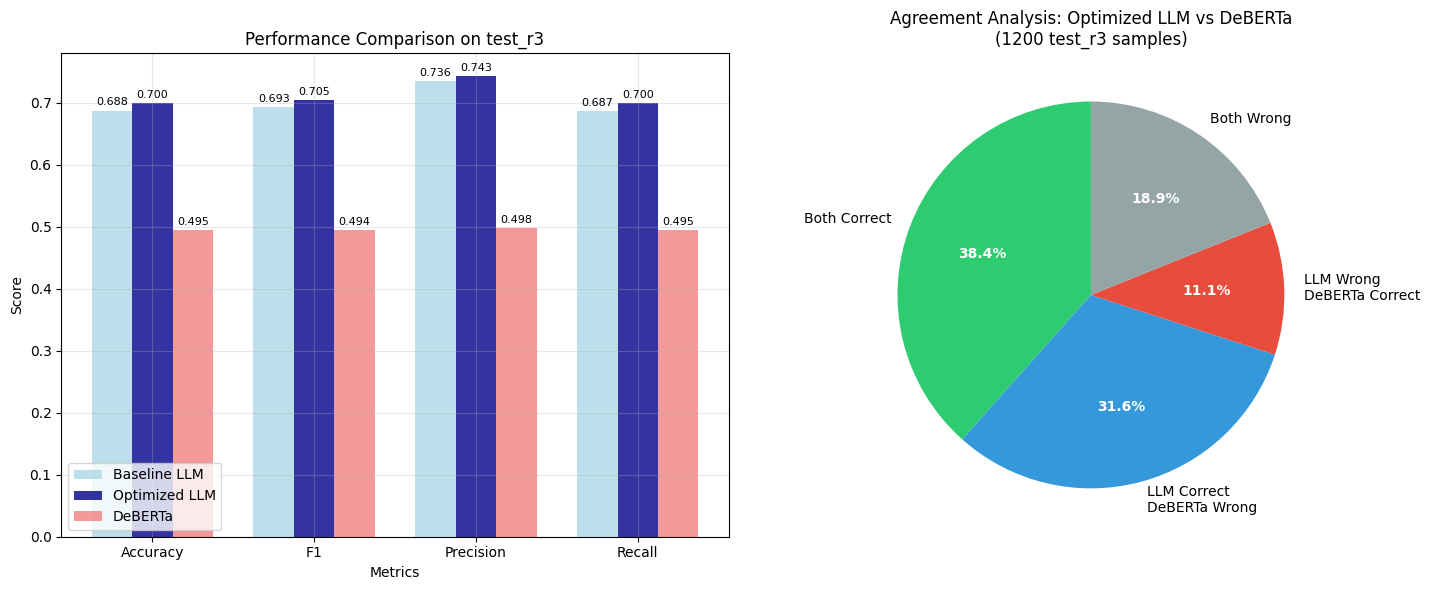

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create detailed comparison table for test_r3
print("\nDETAILED PERFORMANCE COMPARISON (test_r3):")
print("=" * 60)

comparison_df = pd.DataFrame({
    'Model': ['Baseline LLM', 'Optimized LLM', 'DeBERTa'],
    'Accuracy': [baseline_llm_results['accuracy'], optimized_llm_results['accuracy'], deberta_results['accuracy']],
    'F1': [baseline_llm_results['f1'], optimized_llm_results['f1'], deberta_results['f1']],
    'Precision': [baseline_llm_results['precision'], optimized_llm_results['precision'], deberta_results['precision']],
    'Recall': [baseline_llm_results['recall'], optimized_llm_results['recall'], deberta_results['recall']],
    'Samples': [len(references), len(references), len(references)]
})

print(comparison_df.round(4).to_string(index=False))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Performance comparison bar chart
metrics = ['Accuracy', 'F1', 'Precision', 'Recall']
baseline_scores = [baseline_llm_results[m.lower()] for m in metrics]
optimized_scores = [optimized_llm_results[m.lower()] for m in metrics]
deberta_scores = [deberta_results[m.lower()] for m in metrics]

x = np.arange(len(metrics))
width = 0.25

ax1.bar(x - width, baseline_scores, width, label='Baseline LLM', alpha=0.8, color='lightblue')
ax1.bar(x, optimized_scores, width, label='Optimized LLM', alpha=0.8, color='darkblue')
ax1.bar(x + width, deberta_scores, width, label='DeBERTa', alpha=0.8, color='lightcoral')

ax1.set_title('Performance Comparison on test_r3')
ax1.set_xlabel('Metrics')
ax1.set_ylabel('Score')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for i, (baseline_score, optimized_score, deberta_score) in enumerate(zip(baseline_scores, optimized_scores, deberta_scores)):
    ax1.text(i - width, baseline_score + 0.005, f'{baseline_score:.3f}', ha='center', va='bottom', fontsize=8)
    ax1.text(i, optimized_score + 0.005, f'{optimized_score:.3f}', ha='center', va='bottom', fontsize=8)
    ax1.text(i + width, deberta_score + 0.005, f'{deberta_score:.3f}', ha='center', va='bottom', fontsize=8)

# Agreement pie chart
labels = ['Both Correct', 'LLM Correct\nDeBERTa Wrong', 'LLM Wrong\nDeBERTa Correct', 'Both Wrong']
sizes = [agreement['Correct'], agreement['Correct1'], agreement['Correct2'], agreement['Incorrect']]
colors = ['#2ecc71', '#3498db', '#e74c3c', '#95a5a6']

wedges, texts, autotexts = ax2.pie(sizes, labels=labels, autopct='%1.1f%%', 
                                  startangle=90, colors=colors)
ax2.set_title(f'Agreement Analysis: Optimized LLM vs DeBERTa\n({len(references)} test_r3 samples)')

# Make percentage text more readable
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

In [42]:
# Sample predictions analysis for test_r3
print("\nSAMPLE PREDICTIONS ANALYSIS (test_r3):")
print("=" * 60)

label_names = {0: 'Entailment', 1: 'Neutral', 2: 'Contradiction'}

# Show 5 sample examples from test_r3
print("Sample Examples from test_r3:")
for i in range(min(5, len(test_r3_data))):
    example = test_r3_data[i]
    print(f"\nExample {i+1}:")
    print(f"  Premise: {example['premise'][:100]}{'...' if len(example['premise']) > 100 else ''}")
    print(f"  Hypothesis: {example['hypothesis'][:80]}{'...' if len(example['hypothesis']) > 80 else ''}")
    print(f"  True Label: {label_names[references[i]]} ({references[i]})")
    print(f"  Baseline LLM: {label_names[baseline_llm_predictions[i]]} ({baseline_llm_predictions[i]}) {'✓' if baseline_llm_predictions[i] == references[i] else '✗'}")
    print(f"  Optimized LLM: {label_names[optimized_llm_predictions[i]]} ({optimized_llm_predictions[i]}) {'✓' if optimized_llm_predictions[i] == references[i] else '✗'}")
    print(f"  DeBERTa: {label_names[deberta_predictions[i]]} ({deberta_predictions[i]}) {'✓' if deberta_predictions[i] == references[i] else '✗'}")
    print(f"  LLM-DeBERTa Agreement: {'Yes' if optimized_llm_predictions[i] == deberta_predictions[i] else 'No'}")

# Performance improvement analysis
print(f"\n{'='*60}")
print("DSPy OPTIMIZATION IMPACT ON test_r3:")
print(f"{'='*60}")

llm_optimization_improvement = {
    'accuracy': optimized_llm_results['accuracy'] - baseline_llm_results['accuracy'],
    'f1': optimized_llm_results['f1'] - baseline_llm_results['f1'],
    'precision': optimized_llm_results['precision'] - baseline_llm_results['precision'],
    'recall': optimized_llm_results['recall'] - baseline_llm_results['recall']
}

print("Performance improvements from DSPy optimization:")
for metric, improvement in llm_optimization_improvement.items():
    print(f"  {metric.capitalize()}: {improvement:+.4f}")

# Final summary
print(f"\n{'='*60}")
print("FINAL SUMMARY (test_r3 evaluation):")
print(f"{'='*60}")
print(f"Dataset: ANLI test_r3 partition")
print(f"Samples evaluated: {len(references)}")
print(f"Samples with non-empty 'reason' field: {len(references)}")
print(f"\nBest performing model: {max(['Baseline LLM', 'Optimized LLM', 'DeBERTa'], key=lambda x: [baseline_llm_results['accuracy'], optimized_llm_results['accuracy'], deberta_results['accuracy']][['Baseline LLM', 'Optimized LLM', 'DeBERTa'].index(x)])}")
print(f"Highest accuracy: {max(baseline_llm_results['accuracy'], optimized_llm_results['accuracy'], deberta_results['accuracy']):.4f}")
print(f"DSPy optimization {'improved' if accuracy_improvement > 0 else 'did not improve'} LLM performance")


SAMPLE PREDICTIONS ANALYSIS (test_r3):
Sample Examples from test_r3:

Example 1:
  Premise: It is Sunday today, let's take a look at the most popular posts of the last couple of days. Most of ...
  Hypothesis: The day of the passage is usually when Christians praise the lord together
  True Label: Entailment (0)
  Baseline LLM: Neutral (1) ✗
  Optimized LLM: Neutral (1) ✗
  DeBERTa: Neutral (1) ✗
  LLM-DeBERTa Agreement: Yes

Example 2:
  Premise: By The Associated Press WELLINGTON, New Zealand (AP) — All passengers and crew have survived a crash...
  Hypothesis: No children were killed in the accident.
  True Label: Entailment (0)
  Baseline LLM: Entailment (0) ✓
  Optimized LLM: Neutral (1) ✗
  DeBERTa: Neutral (1) ✗
  LLM-DeBERTa Agreement: Yes

Example 3:
  Premise: Tokyo - Food group Nestle is seeking to lure Japanese holiday shoppers with a taste for fine snackin...
  Hypothesis: Japanese like kit kat. 
  True Label: Entailment (0)
  Baseline LLM: Neutral (1) ✗
  Optimized LLM: 